# Gas Price Modeling

We train a GRU recurrent model to forecast the next `S` gas prices (multistep forecasting). For this, we add a linear layer on the GRU's output to map the latent space to `S` future gas prices

In [1]:
# Install the `deep_gas_oracle` package !
!pip install ../

from pathlib import Path
import numpy as np
import pandas as pd
import torch
import matplotlib.pyplot as plt

from deep_gas_oracle.preprocessing.norm import Normalizer
from deep_gas_oracle.modeling.model import GruMultiStep

Processing /home/luisao/perso/deep_gas_oracle


  Created wheel for deep-gas-oracle: filename=deep_gas_oracle-0.1-py3-none-any.whl size=13466 sha256=929aa4c421bac7fe7f6a427ea44a43a18e65a57590ed5c7b2317ea1ac01ffad6
  Stored in directory: /tmp/pip-ephem-wheel-cache-1pmtncfh/wheels/46/91/5b/04f12a63a74ba37fbc1e784aa0ede91818e9dbd7fd97630ca3
Successfully built deep-gas-oracle
  Attempting uninstall: deep-gas-oracle
    Found existing installation: deep-gas-oracle 0.1
    Uninstalling deep-gas-oracle-0.1:
      Successfully uninstalled deep-gas-oracle-0.1


## Configs

In [2]:
configs = {
    "TRAIN_RATIO": 0.7,
    "FEATURES": ["mean_gas_price", "min_gas_price", "max_gas_price", "mean_gas_price_24h_lagged", "eth_usd_price"],
    "TARGETS": ["min_gas_price"],
    "WINDOW_SIZE": 200,
    "PREDICT_SIZE": 36, ## 3h forecast length
    "HIDDEN_SIZE": 16,
    "NUM_LAYERS": 1,
    "LEARNING_RATE": 0.001,
    "NORM_CLIP": 1.0,
    "BATCH_SIZE": 32,
    "EPOCHS": 30,
    "LINEAR_GAIN": True, # This is to give more weights to the end of the window
    "SMOOTH_FRACTION": 0.3, # A lower value of smooth_fraction will result in a smoother curve
    "PATHS": {
        "TRAIN_DATASET_PATH": "../outputs/train_normalized.parquet",
        "TEST_DATASET_PATH": "../outputs/test_normalized.parquet",
        "SCALER_PATH": "../outputs/scaler.pickle",
        "RUNS_DIR_PATH": "../outputs/runs",
    },
    "DEVICE": "cpu"
}

## Train data loading

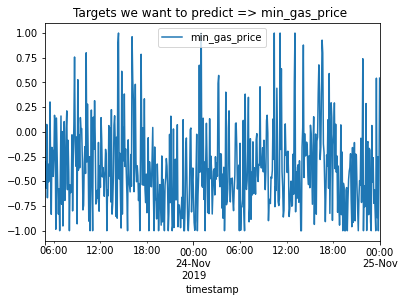

In [3]:
df = pd.read_parquet(configs["PATHS"]["TRAIN_DATASET_PATH"])
train_len = int(len(df) * configs["TRAIN_RATIO"])
train_df = df[:train_len]
val_df = df[train_len:]

plot = val_df[configs["TARGETS"]].plot(title="Targets we want to predict => min_gas_price ")

## Model definition

In [4]:
model = GruMultiStep(features=configs["FEATURES"],
                     targets=configs["TARGETS"],
                     input_length=configs["WINDOW_SIZE"],
                     output_length=configs["PREDICT_SIZE"],
                     hidden_size=configs["HIDDEN_SIZE"],
                     num_layers=configs["NUM_LAYERS"],
                     learning_rate=0.001,
                     linear_gain=configs["LINEAR_GAIN"],
                     norm_clip=configs["NORM_CLIP"],
                     device=configs["DEVICE"],
                     logs_dir=configs["PATHS"]["RUNS_DIR_PATH"])


Parameters (param name -> param count):
	gru.weight_ih_l0 -> 240
	gru.weight_hh_l0 -> 768
	gru.bias_ih_l0 -> 48
	gru.bias_hh_l0 -> 48
	linear_head.weight -> 576
	linear_head.bias -> 36
Total param count: 1716


## Model training

In [5]:
model.fit(train_df, val_df, configs["BATCH_SIZE"], configs["EPOCHS"])

Train Dataset Len: 973
Estimated steps train: 30


/home/luisao/conda_main/lib/python3.8/site-packages/torch/autograd/__init__.py:130: UserWarning: CUDA initialization: Found no NVIDIA driver on your system. Please check that you have an NVIDIA GPU and installed a driver from http://www.nvidia.com/Download/index.aspx (Triggered internally at  /pytorch/c10/cuda/CUDAFunctions.cpp:100.)
  Variable._execution_engine.run_backward(


EPOCH 1 completed:
  train loss: 0.25018363843361535
  val loss: 0.17418986558914185

EPOCH 2 completed:
  train loss: 0.2092897703250249
  val loss: 0.15141810476779938

EPOCH 3 completed:
  train loss: 0.15779556532700856
  val loss: 0.11625335365533829

EPOCH 4 completed:
  train loss: 0.13355879709124566
  val loss: 0.10228396207094193

EPOCH 5 completed:
  train loss: 0.12598585709929466
  val loss: 0.09883265197277069

EPOCH 6 completed:
  train loss: 0.12342999378840129
  val loss: 0.0970526784658432

EPOCH 7 completed:
  train loss: 0.12198838864763578
  val loss: 0.09776651114225388

EPOCH 8 completed:
  train loss: 0.12092536712686221
  val loss: 0.0989023968577385

EPOCH 9 completed:
  train loss: 0.11961052442590396
  val loss: 0.09935514628887177

EPOCH 10 completed:
  train loss: 0.11752685705820719
  val loss: 0.106618233025074

EPOCH 11 completed:
  train loss: 0.11439798424641291
  val loss: 0.12359753251075745



KeyboardInterrupt: 

## Model evaluation

## Tensorboard dashboard

In [6]:
%load_ext tensorboard
%tensorboard --logdir=../outputs/runs/exp_1

Reusing TensorBoard on port 6006 (pid 22218), started 8:14:41 ago. (Use '!kill 22218' to kill it.)

## Predictions plots

In [7]:
EXP = "exp_1"
WEIGHTS = "epoch_best.pth"
PATH = Path(configs["PATHS"]["RUNS_DIR_PATH"]) / EXP / "weights" / WEIGHTS

model = GruMultiStep(features=configs["FEATURES"],
                     targets=configs["TARGETS"],
                     input_length=configs["WINDOW_SIZE"],
                     output_length=configs["PREDICT_SIZE"],
                     hidden_size=configs["HIDDEN_SIZE"],
                     num_layers=configs["NUM_LAYERS"],
                     device=configs["DEVICE"],
                     logs_dir=configs["PATHS"]["RUNS_DIR_PATH"])

model.load_state_dict(torch.load(PATH))
model

Parameters (param name -> param count):
	gru.weight_ih_l0 -> 240
	gru.weight_hh_l0 -> 768
	gru.bias_ih_l0 -> 48
	gru.bias_hh_l0 -> 48
	linear_head.weight -> 576
	linear_head.bias -> 36
Total param count: 1716


GruMultiStep(
  (gru): GRU(5, 16, batch_first=True)
  (linear_head): Linear(in_features=16, out_features=36, bias=True)
  (loss_func): MSELoss()
)

In [8]:
df = pd.read_parquet(configs["PATHS"]["TEST_DATASET_PATH"])
scaler = Normalizer.load_from_file(configs["PATHS"]["SCALER_PATH"])
df_preds, df_ground_truth = model.predict(df, scaler=scaler, normalize=False, denormalize=True, use_ground_truth=True)

### First timestamps predictions (5 minutes ahead)

<AxesSubplot:>

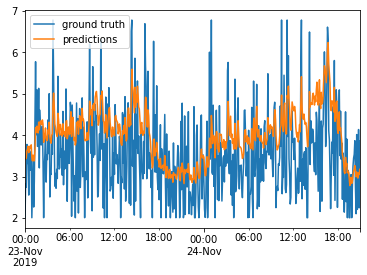

In [9]:
df_pred_t_0 = df_preds["min_gas_price_0"].copy()
df_gt_t_0 = df_ground_truth["min_gas_price_0"].copy()
df_pred_t_0 = df_pred_t_0["2019-11-23":]
df_gt_t_0 = df_gt_t_0["2019-11-23":]
df_pred_t_0 = df_pred_t_0.rename("predictions")
df_gt_t_0 = df_gt_t_0.rename("ground truth")

df_pred_vs_groud_truth = pd.concat([df_gt_t_0, df_pred_t_0], axis=1)
df_pred_vs_groud_truth.plot()

### Random predictions on the `S` forecasted timestamps

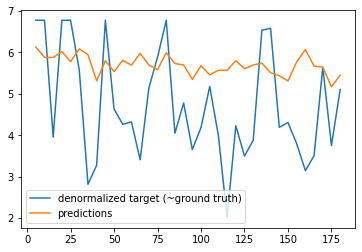

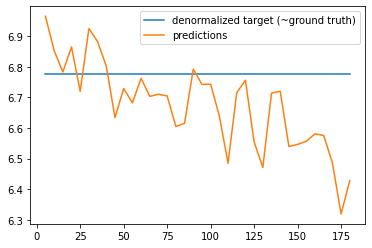

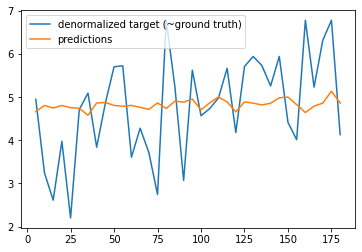

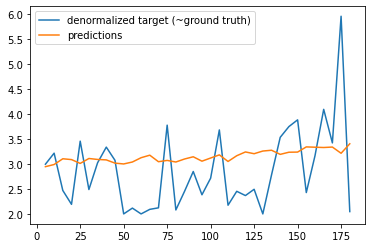

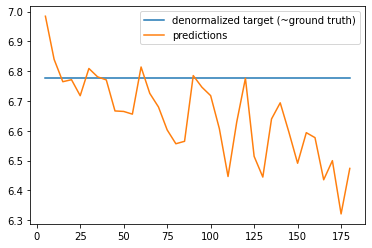

In [16]:
NUM_OF_PLOTS = 5
indexes = np.random.randint(0, len(df_ground_truth), size=NUM_OF_PLOTS)

for i in indexes:
    ground_truths = df_ground_truth.iloc[i, :]
    predictions = df_preds.iloc[i, :]
    t = np.linspace(5, len(predictions)*5, len(predictions))
    plt.plot(t, ground_truths, label = "denormalized target (~ground truth)")
    plt.plot(t, predictions, label = "predictions")
    plt.legend()
    plt.show()